In [1]:
# ============================================================
# Load one (or multiple) isotherms using a CaseConfig class
# and build X from an explicit COLS_TO_INCLUDE list
# ============================================================

import sys
from pathlib import Path
from dataclasses import dataclass
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
# Optional (only if you truly need these in this script)
sys.path.append("..")
from flame_analysis_model import *  # noqa: F401,F403

# ============================================================
# INPUT PARAMETERS (CAPITALS)
# ============================================================

TIME_STEP = 212
PHI = 0.40
LAT_SIZE = "100"
T_REF = 298
P_REF = 5e05

ISOLEVELS = [4.0]  # one isotherm; can be e.g. [3.5, 4.0, 4.5]

MULTIPLE_RUNS = False
N_RUN = 2  # used only if MULTIPLE_RUNS=True

SORET_TERM = False
SORET_POSITIVE = False
POST = True

BASE_DIR = Path("../data/isocontours")

TARGET_VAR = "DW_FDS"

COLS_TO_INCLUDE = [
    "density_ratio_sigma",
    "abs_flame_prop_vel_normal",
    "curvature",
    "total_heat_conduction",
    "flow_velocity_tangential",
    "stretch_rate",
    "H2O",
    "strain_rate",
    "u",
    "tangential_strain_rate",
]

# If you need an exclusion list for other workflows, keep it consistent:
COLS_TO_EXCLUDE = ["x", "y", "z", "N2", "omega_N2", "c_iso", "T", TARGET_VAR]


# ============================================================
# CASE CLASS + IO HELPERS
# ============================================================

@dataclass(frozen=True)
class CaseConfig:
    phi: float
    lat_size: str
    time_step: int
    post: bool
    multiple_runs: bool
    n_run: int
    soret_term: bool
    soret_positive: bool
    h_tag: str = "h400"


def case_folder(cfg: CaseConfig) -> Path:
    """
    Reconstruct your folder logic:
      ../data/isocontours/phi{phi}/h400x{lat_size}_ref[_Soret_positive][/RUN0{n_run}]
    """
    phi_dir = BASE_DIR / f"phi{cfg.phi:.2f}"

    if cfg.soret_term and cfg.soret_positive:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref_Soret_positive"
    else:
        folder = phi_dir / f"{cfg.h_tag}x{cfg.lat_size}_ref"

    if cfg.multiple_runs:
        folder = folder / f"RUN0{cfg.n_run}"

    return folder


def isofile_name(cfg: CaseConfig, c_val: float) -> str:
    if cfg.post:
        return f"extracted_flame_front_post_{cfg.time_step}_iso_{c_val}.csv"
    return f"extracted_flame_front_{cfg.time_step}_iso_{c_val}.csv"


def load_isocontours(cfg: CaseConfig, isolevels: list[float]) -> dict[float, pd.DataFrame]:
    folder = case_folder(cfg)
    dataset: dict[float, pd.DataFrame] = {}

    for c_val in isolevels:
        fpath = folder / isofile_name(cfg, c_val)
        if not fpath.exists():
            raise FileNotFoundError(f"Missing file:\n  {fpath}")

        df = pd.read_csv(fpath).copy()
        df["c_iso"] = float(c_val)
        dataset[float(c_val)] = df

    return dataset


def concat_fronts(dataset: dict[float, pd.DataFrame]) -> pd.DataFrame:
    return pd.concat(list(dataset.values()), ignore_index=True)


# ============================================================
# MAIN
# ============================================================

CASE = CaseConfig(
    phi=PHI,
    lat_size=LAT_SIZE,
    time_step=TIME_STEP,
    post=POST,
    multiple_runs=MULTIPLE_RUNS,
    n_run=N_RUN,
    soret_term=SORET_TERM,
    soret_positive=SORET_POSITIVE,
)

dataset = load_isocontours(CASE, ISOLEVELS)
df_all = concat_fronts(dataset)

# Keep only columns that exist (prevents crashes if one name differs)
missing = [c for c in COLS_TO_INCLUDE if c not in df_all.columns]
if missing:
    raise ValueError(f"These requested features are missing from df_all: {missing}")

feature_cols = [c for c in df_all.columns if c in COLS_TO_INCLUDE]

X = df_all[feature_cols].to_numpy()
print("Selected features:", feature_cols)
print("X shape:", X.shape)
print("Number of selected features:", X.shape[1])


In [11]:
torch.cuda.empty_cache()

In [32]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# Move data to GPU
ambient_dim = X.shape[1]
X_torch = torch.from_numpy(X).float().to(device)

width = ambient_dim * 8
# Define models and move to GPU
encoder = MLP(ambient_dim, ambient_dim, [width] * 4).to(device)
decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4).to(device)

opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

eta, l = 0.01, 0.04

for i in range(40000):
    opt.zero_grad()
    z = encoder(X_torch)
    rec_loss = F.mse_loss(decoder(z), X_torch)
    vol_loss = torch.exp(torch.log(z.std(0) + eta).mean())
    loss = rec_loss + l * vol_loss
    loss.backward()
    opt.step()

    if (i + 1) % 1000 == 0:
        print(f'Epoch {i + 1:4}: rec = {rec_loss.item():.5g}, vol = {vol_loss.item():.5g}')


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU
Epoch 1000: rec = 0.22389, vol = 3.0669
Epoch 2000: rec = 0.092849, vol = 2.0231
Epoch 3000: rec = 0.029531, vol = 0.97238
Epoch 4000: rec = 0.019821, vol = 0.94483
Epoch 5000: rec = 0.0156, vol = 0.78701
Epoch 6000: rec = 0.011959, vol = 0.722
Epoch 7000: rec = 0.01077, vol = 0.67191
Epoch 8000: rec = 0.0097714, vol = 0.6748
Epoch 9000: rec = 0.010925, vol = 0.58304
Epoch 10000: rec = 0.010074, vol = 0.58134
Epoch 11000: rec = 0.0073303, vol = 0.57543
Epoch 12000: rec = 0.0073613, vol = 0.50922
Epoch 13000: rec = 0.0067602, vol = 0.4196
Epoch 14000: rec = 0.0071164, vol = 0.37557
Epoch 15000: rec = 0.0056998, vol = 0.34515
Epoch 16000: rec = 0.0050736, vol = 0.35216
Epoch 17000: rec = 0.0042628, vol = 0.35855
Epoch 18000: rec = 0.0038555, vol = 0.34389
Epoch 19000: rec = 0.015108, vol = 0.34957
Epoch 20000: rec = 0.0038152, vol = 0.33872
Epoch 21000: rec = 0.0028667, vol = 0.32997
Epoch 22000: rec = 0.003374, vol = 0.33272

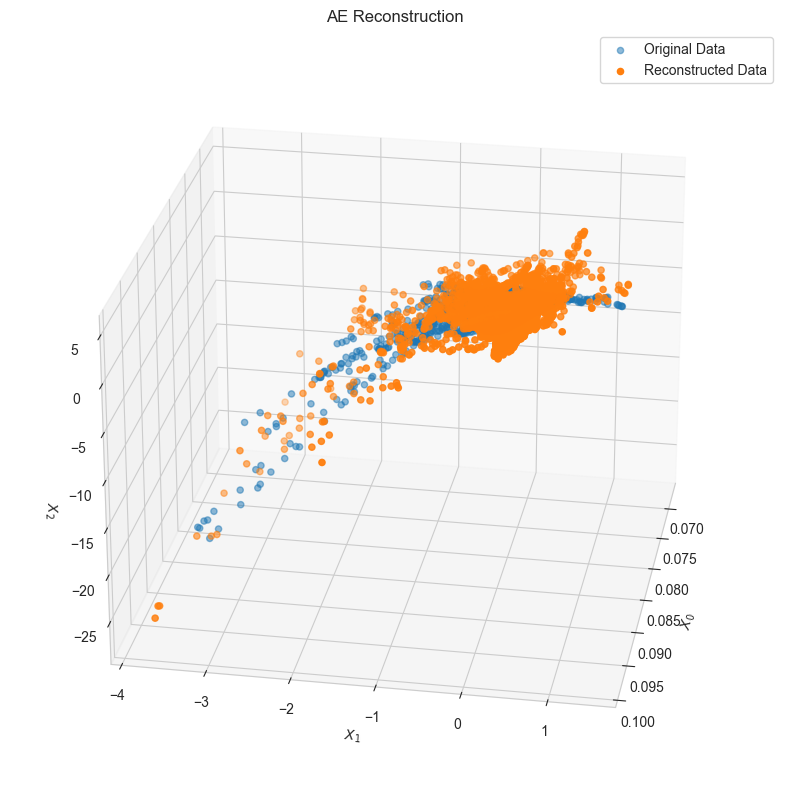

In [33]:

# Move data back to CPU for plotting
encoder.eval()
decoder.eval()

with torch.no_grad():
    X_P = decoder(encoder(X_torch)).cpu().numpy()

X_np = X_torch.cpu().numpy()

# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], alpha=0.5)
ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev = 25
ax.azim = 10
plt.legend(['Original Data', 'Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

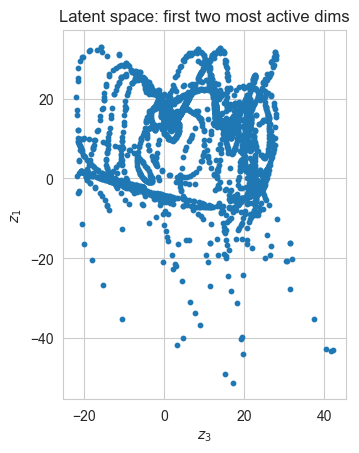

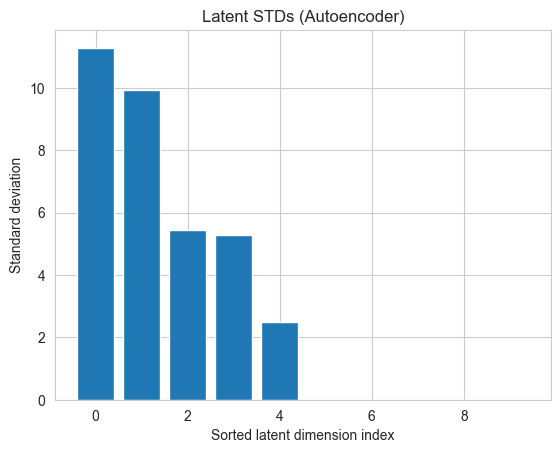

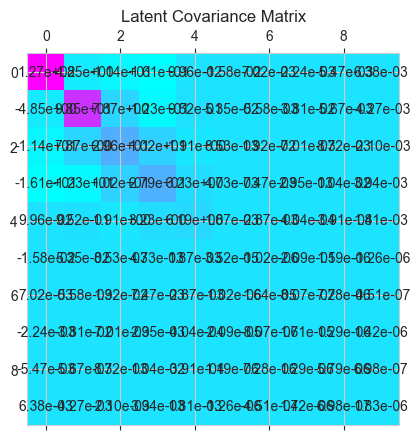

<Figure size 640x480 with 0 Axes>

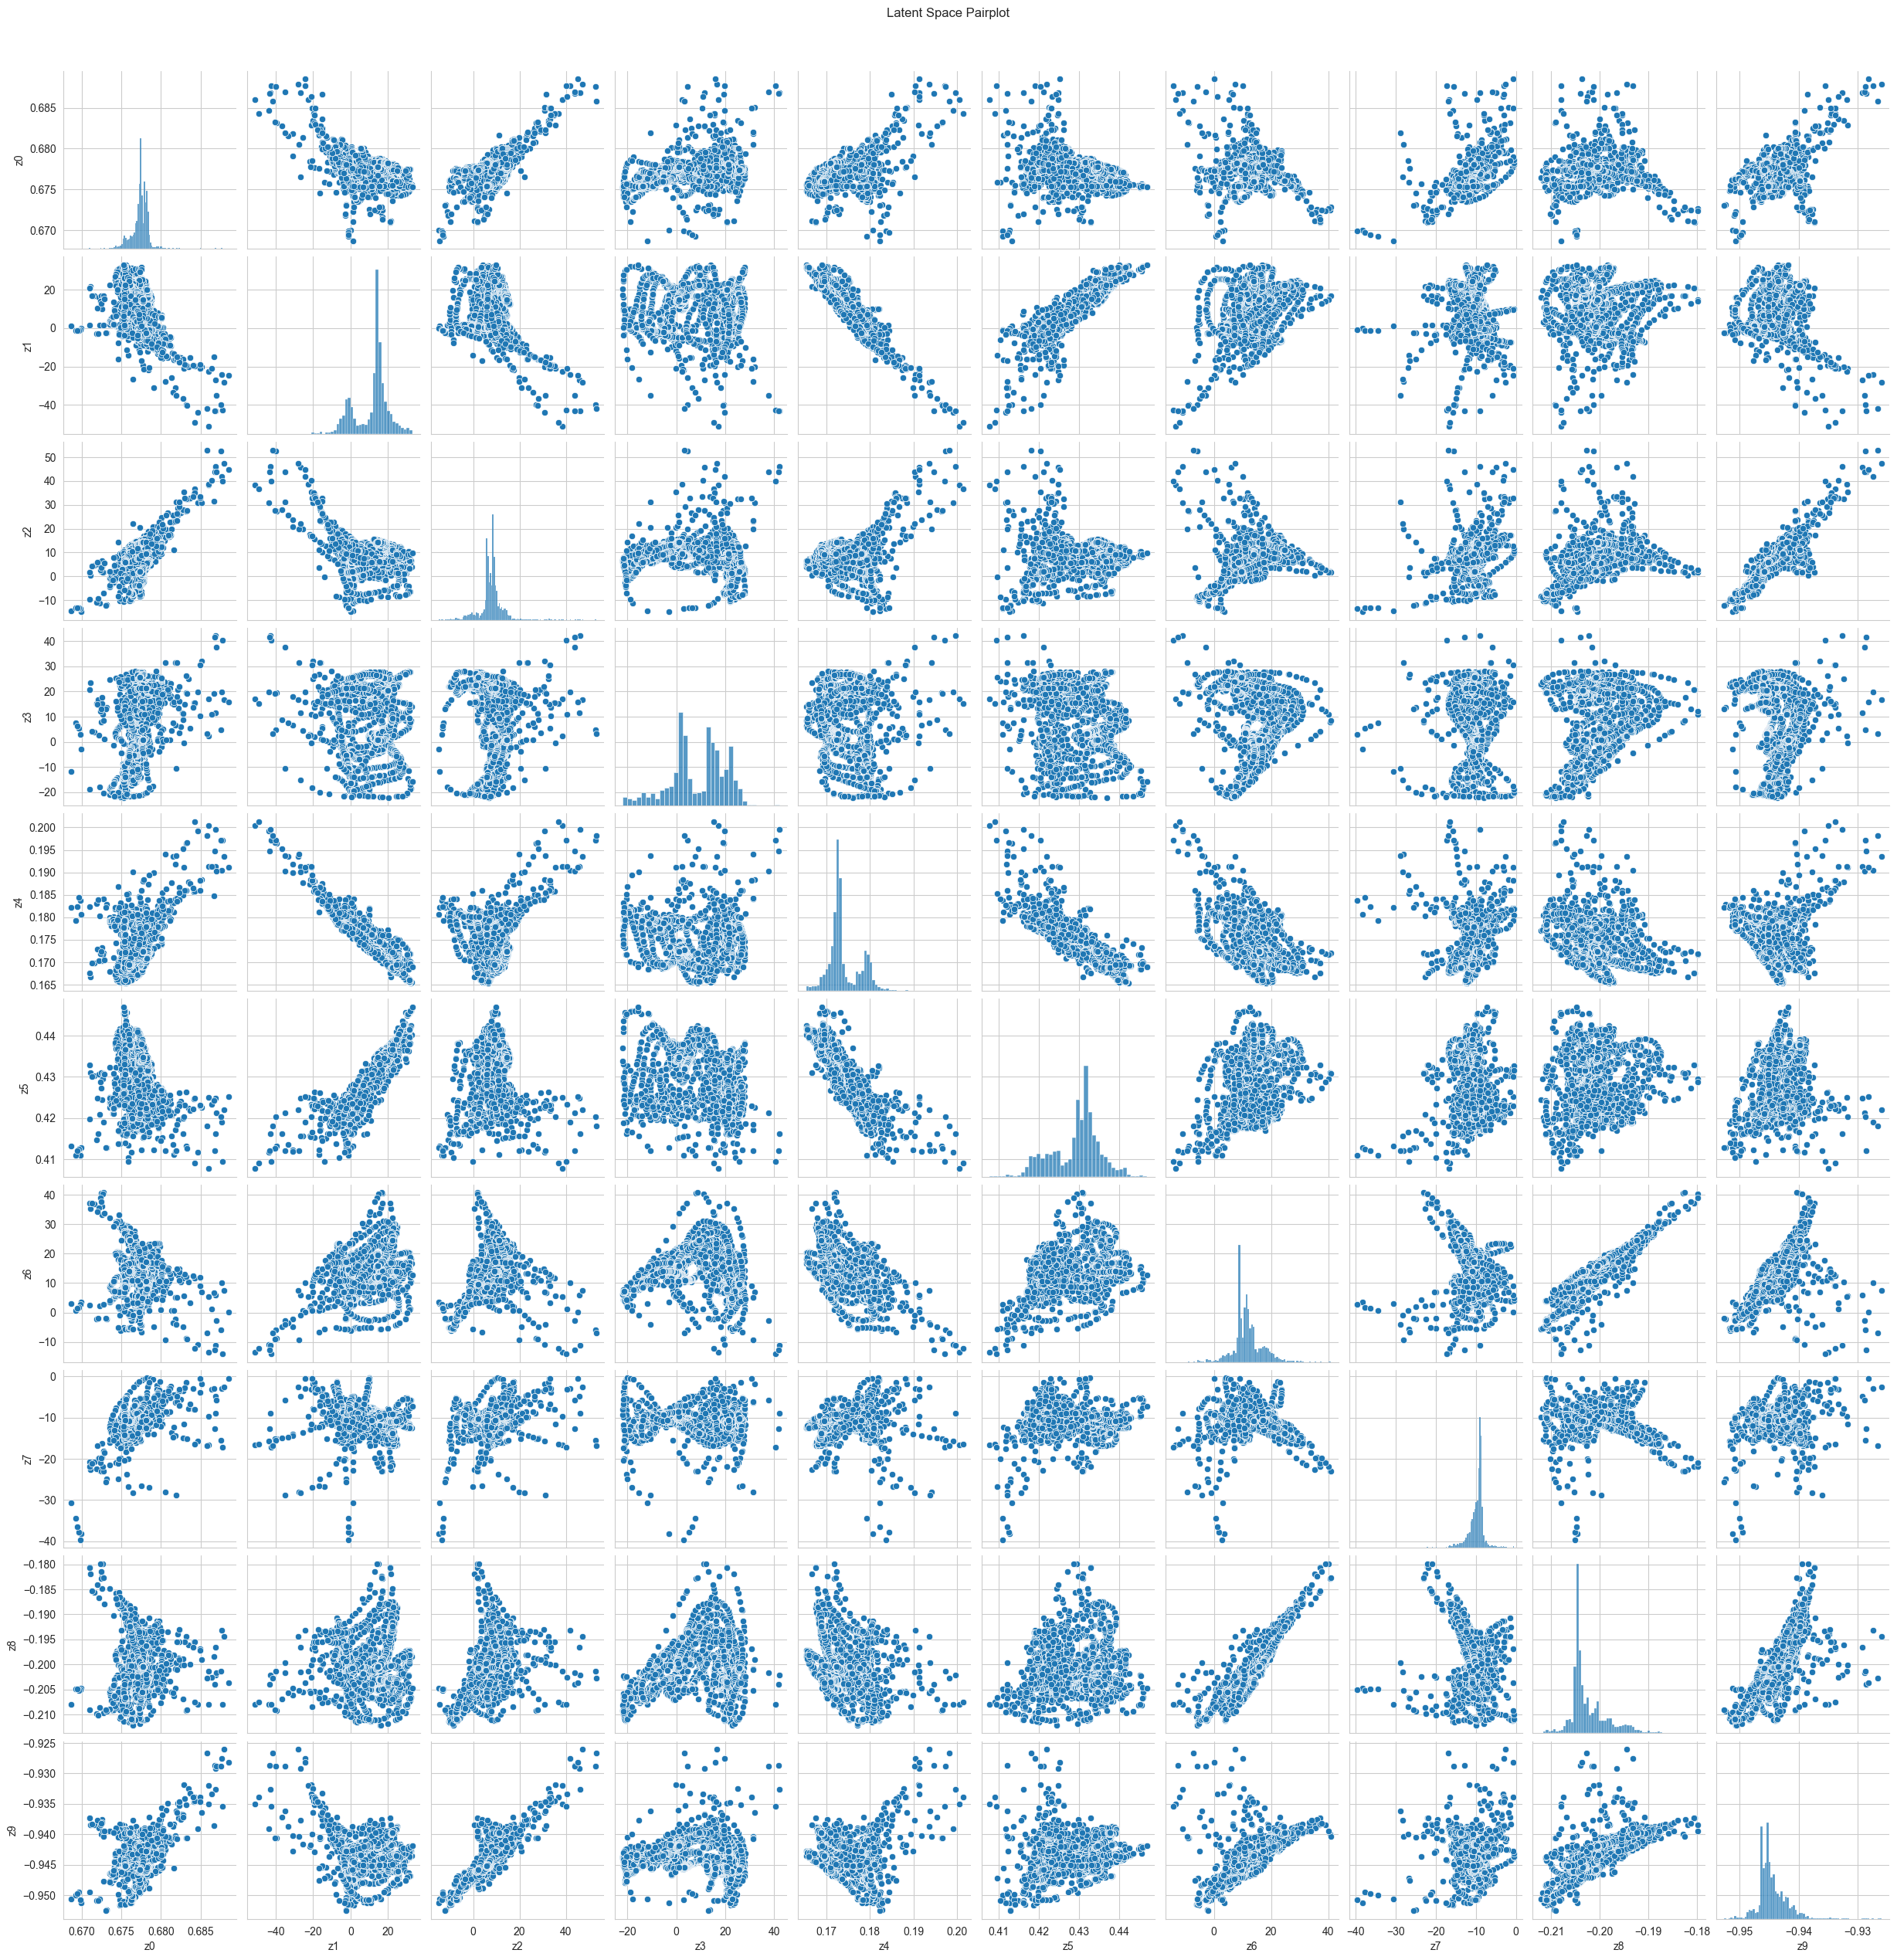

In [34]:

# Switch to eval mode and disable gradient tracking
encoder.eval()
decoder.eval()
with torch.no_grad():
    z = encoder(X_torch)

# Move latent vectors to CPU once and convert to NumPy
z_np = z.detach().cpu().numpy()

# Rank dimensions by standard deviation (importance)
idx = z.std(0).argsort(descending=True)

# ---- Plot 1: z0 vs z1 ----
plt.figure()
plt.scatter(z_np[:, idx[0]], z_np[:, idx[1]], s=10)
plt.gca().set_aspect('equal')
plt.xlabel(f'$z_{{{idx[0]}}}$')
plt.ylabel(f'$z_{{{idx[1]}}}$')
plt.title('Latent space: first two most active dims')
plt.show()

# Compute and sort latent STDs
z_std = z.std(0).detach().cpu().numpy()
idx = z.std(0).detach().cpu().argsort(descending=True)

# Plot
plt.figure()
plt.bar(np.arange(len(z_std)), z_std[idx])
plt.title('Latent STDs (Autoencoder)')
plt.xlabel('Sorted latent dimension index')
plt.ylabel('Standard deviation')
plt.show()

cov = z.T[idx].cov().detach().cpu().numpy()
plt.matshow(cov, cmap='cool')
for (i, j), var in np.ndenumerate(cov):
    plt.gca().text(j, i, '{:.2e}'.format(var), ha='center', va='center')
plt.title('Latent Covariance Matrix')
plt.show()
df_GLV = pd.DataFrame(z.cpu().detach().numpy(), columns=[f'z{i}' for i in range(z.shape[1])])
plt.figure()
sns.pairplot(df_GLV)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

Top-4 latent indices (by std): [3 1 6 2]
Selected feature columns: ['H2O', 'curvature', 'stretch_rate', 'abs_flame_prop_vel_normal', 'flow_velocity_tangential', 'strain_rate', 'tangential_strain_rate', 'density_ratio_sigma', 'total_heat_conduction', 'u']

Correlation |corr(feature, z_k)|:
         H2O  curvature  stretch_rate  abs_flame_prop_vel_normal  \
z3  0.075139   0.011502      0.034288                   0.341840   
z1  0.814054   0.766294      0.730043                   0.281404   
z6  0.023852   0.395434      0.390076                   0.685027   
z2  0.127447   0.438827      0.499099                   0.453383   

    flow_velocity_tangential  strain_rate  tangential_strain_rate  \
z3                  0.925691     0.056141                0.094481   
z1                  0.033702     0.151938                0.556545   
z6                  0.387800     0.276774                0.293506   
z2                  0.486473     0.040490                0.629940   

    density_ratio_sigma

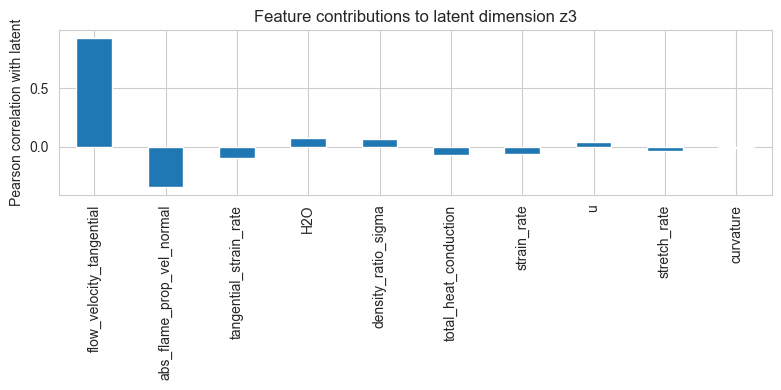

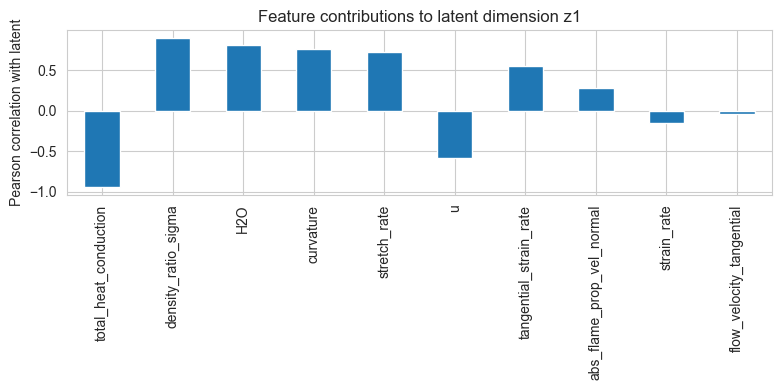

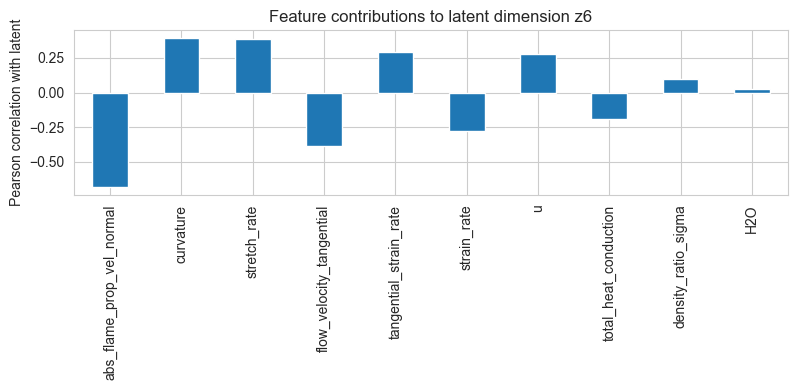

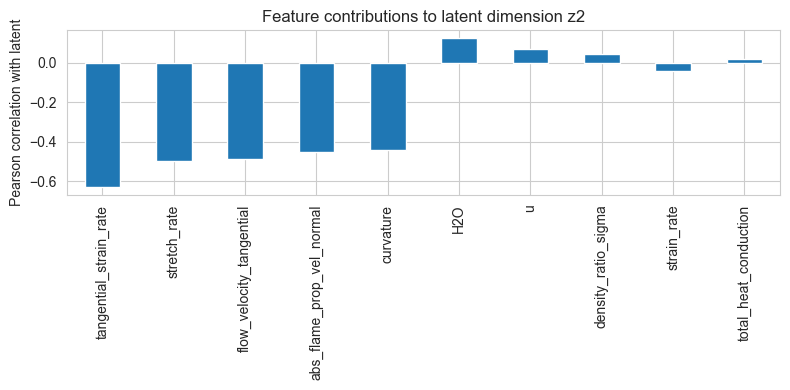

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Get top-4 latent dimensions by standard deviation
# ------------------------------------------------------------
# idx was created as: idx = z.std(0).detach().cpu().argsort(descending=True)
if hasattr(idx, "cpu"):
    idx_top4 = idx[:4].cpu().numpy()
else:
    idx_top4 = np.array(idx[:4])

z_np = z.detach().cpu().numpy()   # N x latent_dim
X_np = X                          # N x 10 (your selected features)

print("Top-4 latent indices (by std):", idx_top4)
print("Selected feature columns:", feature_cols)

# ------------------------------------------------------------
# 2) Correlation between each latent dim and each original feature
# ------------------------------------------------------------
corr_matrix = np.zeros((len(idx_top4), X_np.shape[1]))  # (4 x 10)

for k_pos, k in enumerate(idx_top4):
    z_k = z_np[:, k]
    for j in range(X_np.shape[1]):
        x_j = X_np[:, j]
        # guard against degenerate std
        if np.std(x_j) < 1e-12 or np.std(z_k) < 1e-12:
            corr = 0.0
        else:
            corr = np.corrcoef(x_j, z_k)[0, 1]
        corr_matrix[k_pos, j] = corr

corr_df = pd.DataFrame(
    corr_matrix,
    index=[f"z{int(k)}" for k in idx_top4],
    columns=feature_cols,
)

print("\nCorrelation |corr(feature, z_k)|:")
print(corr_df.abs())

# ------------------------------------------------------------
# 3) Bar plots: for each latent dim, which features correlate most?
# ------------------------------------------------------------
for k_pos, k in enumerate(idx_top4):
    series = pd.Series(corr_matrix[k_pos, :], index=feature_cols)
    series_sorted = series.reindex(series.abs().sort_values(ascending=False).index)

    plt.figure(figsize=(8, 4))
    series_sorted.plot(kind="bar")
    plt.ylabel("Pearson correlation with latent")
    plt.title(f"Feature contributions to latent dimension z{int(k)}")
    plt.tight_layout()
    plt.show()


In [36]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 1) Prepare data
# ------------------------------------------------------------
target_var = "DW_FDS"

if target_var not in df_all.columns:
    raise ValueError(f"Column '{target_var}' not found in df_all.")

y_all = df_all[target_var].to_numpy()

# Mask out any NaNs / infs in X, z, or y
mask = np.isfinite(y_all)
mask &= np.isfinite(X_np).all(axis=1)
mask &= np.isfinite(z_np).all(axis=1)

X_all = X_np[mask, :]                       # N x 10
y = y_all[mask]                             # N
Z4 = z_np[mask][:, idx_top4]                # N x 4

print(f"\nAfter masking NaNs/Infs: {X_all.shape[0]} samples remain.")
print("X_all shape:", X_all.shape)
print("Z4 shape   :", Z4.shape)

total_var = np.var(y, ddof=1)
print(f"Total variance of {target_var}: {total_var:.6e}")

# ------------------------------------------------------------
# 2) Single train/test split (same for both inputs)
# ------------------------------------------------------------
n_samples = y.shape[0]
indices = np.arange(n_samples)

idx_train, idx_test = train_test_split(
    indices, test_size=0.2, random_state=0, shuffle=True
)

def split_and_scale(X, y, idx_train, idx_test):
    X_train = X[idx_train]
    X_test  = X[idx_test]
    y_train = y[idx_train]
    y_test  = y[idx_test]

    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc  = scaler.transform(X_test)
    return X_train_sc, X_test_sc, y_train, y_test, scaler

X10_tr, X10_te, y_tr, y_te, scaler_10 = split_and_scale(X_all, y, idx_train, idx_test)
Z4_tr,  Z4_te,  y_tr_z, y_te_z, scaler_z4 = split_and_scale(Z4,    y, idx_train, idx_test)

# Sanity: y_tr and y_tr_z should be identical
assert np.allclose(y_tr, y_tr_z)

# ------------------------------------------------------------
# 3) Define a small MLP architecture
# ------------------------------------------------------------
def make_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(64, 64),
        activation="relu",
        solver="adam",
        alpha=1e-3,
        learning_rate="adaptive",
        max_iter=500,
        random_state=0,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
    )

mlp_10 = make_mlp()  # using 10 original features
mlp_4  = make_mlp()  # using 4 latent features

# ------------------------------------------------------------
# 4) Train both MLPs
# ------------------------------------------------------------
print("\nTraining MLP with 10 original selected features...")
mlp_10.fit(X10_tr, y_tr)

print("Training MLP with 4 latent AE features...")
mlp_4.fit(Z4_tr, y_tr)

# ------------------------------------------------------------
# 5) Evaluate and compare
# ------------------------------------------------------------
def eval_model(name, model, X_te, y_te, total_var):
    y_pred = model.predict(X_te)
    res = y_te - y_pred
    res_var = np.var(res, ddof=1)
    R2 = 1.0 - res_var / total_var
    print(f"\n=== {name} ===")
    print(f"Residual variance (test): {res_var:.6e}")
    print(f"R^2 vs total var({target_var}): {R2:.4f}")
    return res_var, R2, y_pred

res_var_10, R2_10, ypred_10 = eval_model(
    "MLP with 10 selected features", mlp_10, X10_te, y_te, total_var
)
res_var_4,  R2_4,  ypred_4  = eval_model(
    "MLP with 4 latent AE features", mlp_4, Z4_te,  y_te, total_var
)

if res_var_10 > 0:
    rel_increase = (res_var_4 / res_var_10 - 1) * 100
    print(f"\nRelative change in residual variance (4 latent vs 10 features): {rel_increase:+.2f}%")
    print(f"R^2 (10 features) = {R2_10:.4f}, R^2 (4 latent) = {R2_4:.4f}")



After masking NaNs/Infs: 3963 samples remain.
X_all shape: (3963, 10)
Z4 shape   : (3963, 4)
Total variance of DW_FDS: 2.213175e-01

Training MLP with 10 original selected features...
Training MLP with 4 latent AE features...

=== MLP with 10 selected features ===
Residual variance (test): 2.824524e-04
R^2 vs total var(DW_FDS): 0.9987

=== MLP with 4 latent AE features ===
Residual variance (test): 2.542838e-03
R^2 vs total var(DW_FDS): 0.9885

Relative change in residual variance (4 latent vs 10 features): +800.27%
R^2 (10 features) = 0.9987, R^2 (4 latent) = 0.9885
